<a href="https://colab.research.google.com/github/chavamoon/MachineLearningExamples/blob/main/Feature_Selection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [97]:
import pandas as pd
import numpy as np
import matplotlib
%matplotlib inline
import seaborn as sns

**Objetivo**: Mostrar diferentes técnicas de selección de variables para un modelo de Machine Learning.

## Selección univariada ##

Del dataset de pingüinos se quiere predecir el sexo del pingüino a través de las demás variables.

In [98]:
penguins = sns.load_dataset('penguins')
penguins.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female


Limpiar nulos y convertir a encoding sex (male = 0 y female =1 )

In [99]:
penguins.dropna(inplace=True)
penguins.sex.mask(penguins.sex == 'Male', 0, inplace=True)
penguins.sex.mask(penguins.sex == 'Female', 1, inplace=True)
penguins.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,0
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,1
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,1
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,1
5,Adelie,Torgersen,39.3,20.6,190.0,3650.0,0


get_dummies para convertir categóricos a one hot encoding

drop_first = True para quitar el primer valor del one hot encoding, esto evita problemas de colinealidad (Que una variable del hot encoding esté altamente correlacionada a otra)

https://towardsdatascience.com/how-to-avoid-multicollinearity-in-categorical-data-46eb39d9cd0d

In [100]:
penguins_with_ohe = pd.get_dummies(penguins, columns=['species', 'island'], drop_first=True)
penguins_with_ohe.head()

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,species_Chinstrap,species_Gentoo,island_Dream,island_Torgersen
0,39.1,18.7,181.0,3750.0,0,0,0,0,1
1,39.5,17.4,186.0,3800.0,1,0,0,0,1
2,40.3,18.0,195.0,3250.0,1,0,0,0,1
4,36.7,19.3,193.0,3450.0,1,0,0,0,1
5,39.3,20.6,190.0,3650.0,0,0,0,0,1


### Método de análisis de varianza

La idea es quitar las variables que presenten poca varianza, pes esto es señal de que tienen poca información (poca dispersión de datos). Aunque se recomiendan tambien aplicar otros métodos.

Podemos dividir la varianza entre la media para darnos una idea de la escala en la que se encuentran las variables.

In [101]:
variance = penguins_with_ohe.std() / penguins_with_ohe.mean()
variance

bill_length_mm       0.124308
bill_depth_mm        0.114725
flipper_length_mm    0.069742
body_mass_g          0.191396
sex                  1.010568
species_Chinstrap    1.977068
species_Gentoo       1.343032
island_Dream         1.308610
island_Torgersen     2.470513
dtype: float64

En este caso con poca varianza se detecta la variable flipper_length_mm.

### Método de correlación de Pearson

Usamos el método de correlación de Pearson sobre las variables continuas 'bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g'

In [102]:
pen_continous = penguins_with_ohe[['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g']]
corr =pen_continous.corr()
corr

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g
bill_length_mm,1.000000,-0.228626,0.653096,0.589451
bill_depth_mm,-0.228626,1.000000,-0.577792,-0.472016
flipper_length_mm,0.653096,-0.577792,1.000000,0.872979
body_mass_g,0.589451,-0.472016,0.872979,1.000000


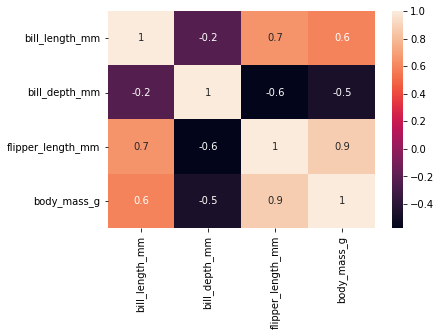

In [103]:
sns.heatmap(corr, annot=True, fmt='.1g')

flipper_length_mm con body_mass_g tienen alta correlación pese a ser variables explicativas, podríamos descartar cualquiera de los dos, puesto que se comportan de manera similar.

### Método de chi-square

Seleccionando solo las variables categóricas (sex, variables del one hot encoding de species y variables del one hot encoding de island) 

In [104]:
from sklearn.feature_selection import chi2

In [105]:
cat_columns = [c for c in penguins_with_ohe.columns if ('island' in c)|('species' in c)]
X = penguins_with_ohe[cat_columns].astype('bool')
y = penguins_with_ohe['sex'].astype('bool')

Chi cuadrada teniendo las variables como One Hot Encoding

In [106]:
chi_sq, p_val = chi2(X,y)
chi_pd = pd.DataFrame({'variable': X.columns, 'chi_sq': chi_sq, 'p_value': p_val})
chi_pd.sort_values(ascending=True, by='p_value')

,variable,chi_sq,p_value
3,island_Torgersen,0.043113,0.835513
1,species_Gentoo,0.031237,0.859713
0,species_Chinstrap,0.005519,0.940777
2,island_Dream,0.000095,0.992222


Hay evidencia de que las variables son independientes.Tienen un p_value mayor a 
*0.05*


Chi cuadrada con variables categóricas con más de un valor (0,1,2 por ejemplo)

In [107]:
cat_columns_2 = [c for c in penguins.columns if ('island' in c)|('species' in c)]

X = penguins[cat_columns_2]
#encode de x para convertir las variables categóricas a números
X.replace({'Torgersen':0, 'Biscoe':1, 'Dream':2}, inplace=True)
X.replace({'Adelie':0, 'Chinstrap':1, 'Gentoo':2}, inplace=True)
y = penguins['sex'].astype('int')

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4389: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


In [108]:
chi_sq, p_val = chi2(X,y)
chi_pd_2 = pd.DataFrame.from_dict({'variable':X.columns,
                        'chi_sq':chi_sq, 'p_value':p_val})
chi_pd_2.sort_values(ascending=True, by='p_value').round(3)

,variable,chi_sq,p_value
0,species,0.034,0.853
1,island,0.004,0.948


Hay evidencia de que las variables son independientes.Tienen un p_value mayor a *0.05*

### Predicciones

Función que hace el split de los datos para entrenamiento y pruebas, adicional a esto si se especifica te escala los valores con StandardScaler

In [109]:
# Preprocess data
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

def preprocess_split(X, y,test_size=0.2,random_state=5874,
                        scale_x=True,
                        cat_variables=[], 
                        scale_y=False):
  
  # Split data
  x_train, x_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=test_size, 
                                                    random_state=random_state)
  # Scale X
  if scale_x:
    # Find numerical column index
    num_i = [X.columns.get_loc(c) for c in X.columns if c not in cat_variables]
    cat_i = [X.columns.get_loc(c) for c in X.columns if c in cat_variables]
    # Scale Numerical Variables
    x_train_ = x_train.iloc[:, num_i]
    x_test_ = x_test.iloc[:, num_i]
    scaler = StandardScaler().fit(x_train_)
    x_train_ = scaler.transform(x_train_)
    x_test_ = scaler.transform(x_test_)
    # Create new dataframe
    x_train = np.concatenate([x_train_, x_train.iloc[:,cat_i]], axis=1)
    x_test = np.concatenate([x_test_, x_test.iloc[:,cat_i]],axis=1)

  # Scale Y
  if scale_y:
    scaler = StandardScaler().fit(y_train)
    y_train = scaler.transform(y_train)
    y_test = scaler.transform(y_test)

  return x_train, x_test, y_train, y_test



Función que hace regresión logística

In [110]:
# Funcion de regresion logistica
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

def log_regression(x_train, x_test, y_train, y_test):
  
  #print(x_train.columns)
  # Train Logistic Model
  model = LogisticRegression()
  model.fit(x_train, y_train)

  #Test the model
  predictions = model.predict(x_test)
  return model,predictions

Se realiza el split y el modelo de regresión logística con todas las variables del dataset de onehotencoding

In [111]:
X = penguins_with_ohe.loc[:, penguins_with_ohe.columns!='sex']
y = penguins_with_ohe['sex'].astype('bool')
cat_variables =  ['species_Chinstrap', 'species_Gentoo', 'island_Dream',
       'island_Torgersen']

x_train, x_test, y_train, y_test = preprocess_split(X, y, scale_x=True, random_state=5874,cat_variables =cat_variables, 
                                                    test_size=0.2)
# type(x_test)
result = log_regression(x_train, x_test, y_train, y_test)
# x_test


In [112]:
from sklearn.metrics import accuracy_score
acurracy = accuracy_score(y_test,result[1])
print ('Accurracy', acurracy)

Accurracy 0.9253731343283582


### Correlación usando datos de entrenamiento ya escalados

---



In [113]:
corr_2 = pd.DataFrame(x_train, columns=X.columns)[['bill_length_mm', 
          'bill_depth_mm', 'flipper_length_mm', 'body_mass_g']].corr()
corr_2

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g
bill_length_mm,1.000000,-0.229741,0.636821,0.567636
bill_depth_mm,-0.229741,1.000000,-0.574732,-0.458960
flipper_length_mm,0.636821,-0.574732,1.000000,0.871594
body_mass_g,0.567636,-0.458960,0.871594,1.000000


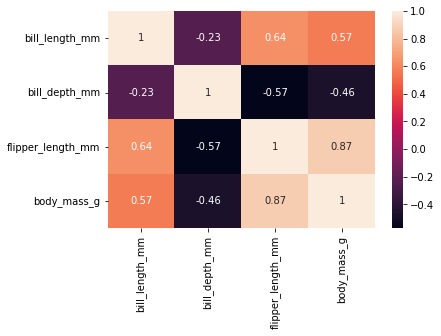

In [114]:
sns.heatmap(corr_2, annot=True)

Las variables explicativas flipper_length_mm y body_mass_g están muy relacionadas. Es posible quitar alguna de ellas (valor casí igual a .9)

### Chi cuadrada usando datos de entrenamiento ya escalados


In [115]:
chi_sq, p_val = chi2(pd.DataFrame(x_train, columns=X.columns)[cat_variables],
                     y_train)
chi_values = pd.DataFrame.from_dict({'variable':cat_variables ,
                         'chi_sq':chi_sq, 'p_value':p_val})
chi_values.sort_values(ascending=True, by='p_value').round(3)

,variable,chi_sq,p_value
0,species_Chinstrap,0.491,0.484
3,island_Torgersen,0.121,0.728
2,island_Dream,0.045,0.832
1,species_Gentoo,0.017,0.898


Hay evidencia de que las variables son independientes a y.Tienen un p_value mayor a *0.05*, por lo que se pueden descartar

### Correlación biserial puntual sobre los datos de entrenamiento

In [116]:
from scipy.stats import pointbiserialr

for c in ['bill_length_mm', 'bill_depth_mm', 
          'flipper_length_mm', 'body_mass_g']:
  pbc = pointbiserialr(pd.DataFrame(x_train, columns=X.columns)[c], y_train)
  print(c, ',sex')
  print('Correlation: ', pbc[0])
  print('P-value: ', pbc[1])
  print()

bill_length_mm ,sex
Correlation:  -0.3058602269043177
P-value:  3.630503092983297e-07

bill_depth_mm ,sex
Correlation:  -0.3995169355545488
P-value:  1.2947885862754276e-11

flipper_length_mm ,sex
Correlation:  -0.22967081783082616
P-value:  0.00015757712772184132

body_mass_g ,sex
Correlation:  -0.40649542217481
P-value:  5.248265271965853e-12



Todos tienen un p-value <0.05, rechazamos que las variables sean independientes, por lo que no descartamos ninguna variable

### Nuevo modelo

De los análisis anteriores descartamos las variables del one hot encoding (empiezan con island o species) y la variable flipper_length_mm y co neso contruimos un nuevo modelo

In [117]:
sub_set = [c for c in X.columns if ('island' not in c)]
sub_set = [c for c in sub_set if ('species' not in c)]
sub_set = [c for c in sub_set if c  != 'flipper_length_mm']

print('Nuevas columnas: para el modelo', sub_set)

X = penguins_with_ohe[sub_set]
y = penguins_with_ohe['sex'].astype('bool')

x_train, x_test, y_train, y_test = preprocess_split(X, y, scale_x=True, 
                                                    test_size=0.2, 
                                                    random_state=5874)
print(X.columns)
result2 = log_regression(x_train, x_test, y_train, y_test)

#viejo accuracy
print ('Accurracy antes de seleccionar variables', acurracy)
#nuevo accuracy

print ('Accurracy después de seleccionar variables', accuracy_score(y_test,result2[1]))

Nuevas columnas: para el modelo ['bill_length_mm', 'bill_depth_mm', 'body_mass_g']
Index(['bill_length_mm', 'bill_depth_mm', 'body_mass_g'], dtype='object')
Accurracy antes de seleccionar variables 0.9253731343283582
Accurracy después de seleccionar variables 0.9253731343283582


Los accuraccy aunque no mejoraron permanecieron igual, pero este nuevo modelo es más sencillo y por lo tanto no consume tantos recursos computacionales

## Feature importance

A través de un RandomForest de clasificador se encuentran las importancias de cada característica.

In [124]:
from sklearn.ensemble import RandomForestClassifier

# define dataset
X = penguins_with_ohe.loc[:, penguins_with_ohe.columns!='sex']
y = penguins_with_ohe['sex'].astype('bool')
x_train, x_test, y_train, y_test = preprocess_split(X, y, scale_x=True, 
                                                    random_state=5874,
                                                    cat_variables =cat_variables, 
                                                    test_size=0.2)
# define the model
model = RandomForestClassifier(random_state=13)
# fit the model
model.fit(x_train, y_train)
# get importance
importance = model.feature_importances_
pd.DataFrame.from_dict({'variable':X.columns,'importance':importance})

,variable,importance
0,bill_length_mm,0.206755
1,bill_depth_mm,0.295730
2,flipper_length_mm,0.120571
3,body_mass_g,0.305485
4,species_Chinstrap,0.018858
5,species_Gentoo,0.034700
6,island_Dream,0.010054
7,island_Torgersen,0.007847


In [125]:
predictions = model.predict(x_test)
print ('Accurracy', accuracy_score(y_test,predictions))

Accurracy 0.9402985074626866


Las variables con un bajo feature_importance no aportan mucho al modelo y podrían descartarse.

1. Como cambia el Feature Importance si utilizamos el modelo sin variables categoricas? 

In [126]:
# define dataset
X = penguins_with_ohe[['bill_length_mm', 
          'bill_depth_mm', 'flipper_length_mm', 'body_mass_g']]
y = penguins_with_ohe['sex'].astype('bool')
x_train, x_test, y_train, y_test = preprocess_split(X, y, scale_x=True, 
                                                    random_state=5874,
                                                    cat_variables =cat_variables, 
                                                    test_size=0.2)
# define the model
model = RandomForestClassifier(random_state=13)
# fit the model
model.fit(x_train, y_train)
# get importance
importance = model.feature_importances_
pd.DataFrame.from_dict({'variable':X.columns,'importance':importance})

,variable,importance
0,bill_length_mm,0.209534
1,bill_depth_mm,0.357001
2,flipper_length_mm,0.115668
3,body_mass_g,0.317797


In [127]:
predictions = model.predict(x_test)
print ('Accurracy', accuracy_score(y_test,predictions))


Accurracy 0.9402985074626866


El feature importance permanece casi igual, esto demuestra que las variables categóricas no estaban aportando mucho

2. Como cambia el Feature Importance si ademas de quitar las variables categoricas, tambien removemos 'flipper_length_mm'?

In [128]:
# define dataset
X = penguins_with_ohe[['bill_length_mm', 
          'bill_depth_mm','body_mass_g']]
y = penguins_with_ohe['sex'].astype('bool')
x_train, x_test, y_train, y_test = preprocess_split(X, y, scale_x=True, 
                                                    random_state=5874,
                                                    cat_variables =cat_variables, 
                                                    test_size=0.2)
# define the model
model = RandomForestClassifier(random_state=13)
# fit the model
model.fit(x_train, y_train)
# get importance
importance = model.feature_importances_
pd.DataFrame.from_dict({'variable':X.columns,'importance':importance})

,variable,importance
0,bill_length_mm,0.293103
1,bill_depth_mm,0.369958
2,body_mass_g,0.336939


In [129]:
predictions = model.predict(x_test)
print ('Accurracy', accuracy_score(y_test,predictions))

Accurracy 0.9701492537313433


Los tres features tienen casi la misma importancia para el modelo.